## Only transmon and cavity and chain!

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as linalg
import math
import time

# Parameters
d = 0.35 #squid asymmetry
g = 0.08 #transmon cavity coupling
Wq0 = 3.474 #dressed qubit frequency
Wc0 = 7.192 #dressed cavity frequency
lamb_shift  = g**2/(Wc0 - Wq0)
Wc = Wc0 - lamb_shift #bare qubit
Wq = Wq0 + lamb_shift #bare cavity


gamma_L = 0.1 # chain coupling to the left josephson junction
gamma_R = gamma_L*(1-d)/(1+d) # chain coupling to the right josephson junction
t = 0.1 # chain hopping
E_C = 0.06 # charging energy
E_J_max = (Wq+E_C)**2/8/E_C
# E_J1 = 1
# E_J2 = E_J1
n_g = 0
N = 0 # number of chain fermions
n_0 = 10 #number of CP
steps = 200
flux_0 = 1 #2.067833*10**(-15)
flux_array = np.linspace(0,2*flux_0,steps)
num_of_eigen = 4
max_num_photons = 6 #number of photons



# Defining the single spin operators s_x, s_y, s_z:
s_x = 0.5*np.array([[0,1],[1,0]], dtype=complex)
s_y = 0.5*np.array([[0,-1j],[1j,0]], dtype=complex)
s_z = 0.5*np.array([[1,0],[0,-1]], dtype=complex)

s_plus = s_x + 1j*s_y
s_minus = s_x - 1j*s_y

# Defining the creation and annihilation operators for the SCs
exp_phi_plus = np.diag(np.ones(2*n_0, dtype=complex), k=-1) # Creation
exp_phi_minus = np.diag(np.ones(2*n_0, dtype=complex), k=1)# Annihilation

# harmonic osc creation and annihilation
occupation = np.arange(1,max_num_photons+1, dtype=complex)
a_down = np.diag(np.sqrt(occupation), k=1)
a_up = np.diag(np.sqrt(occupation), k=-1)
occupation_operator = a_up @ a_down

cutoff = False
size_of_transmon_subspace = 2

In [235]:

def H_Transmon(E_C = E_C, n_0 = n_0, n_g = n_g, E_J_max = E_J_max, d = d, flux=0, cutoff_transmon = False, size_of_subspace = None): #N is the number of cp passed from one sc to the other
    # when cutoff = false I return H,eigenvalues,eigenvectors in the size of the whole transmon space
    # when cutoff = true I return H,eigenvalues,eigenvectors. H in the size of the subspace and eigenvalues,eigenvectors in the size of the whole transmon space
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = 4*E_C*(-n_0+i-n_g)**2
    H = np.diag(D) - (E_J_max/2)*np.sqrt(np.cos(np.pi*flux/(2*flux_0))**2 + (d**2)*np.sin(np.pi*flux/(2*flux_0))**2)*(exp_phi_minus + exp_phi_plus)
    eigenvalues_transmon, eigenvectors_transmon = np.linalg.eig(H)
    # sort eigenvalues and rearrange corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues_transmon)
    sorted_eigenvalues_transmon = eigenvalues_transmon[sorted_indices]
    sorted_eigenvectors_transmon = eigenvectors_transmon[:, sorted_indices]
    if cutoff_transmon: # slice the wanted subspace
        indices_of_transmon = np.array(range(size_of_subspace))
        A = np.dot(np.dot(np.linalg.inv(sorted_eigenvectors_transmon), H), sorted_eigenvectors_transmon)[indices_of_transmon,:][:,indices_of_transmon]
        #print("the H_trans matrix after u_dag*H*U:", A)
        B = np.sum(np.abs(A-np.conj(A.T)))
        print("hermitian of H_trans u_dag*H*U:", B)
        H = np.diag(sorted_eigenvalues_transmon[indices_of_transmon])
    else:
        H = np.diag(sorted_eigenvalues_transmon)
    return H, sorted_eigenvalues_transmon, sorted_eigenvectors_transmon

def H_cavity(Wc = Wc):
    H = Wc*(a_up @ a_down)
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_cav:", B)
    return H

def H_int_transmon_cavity(g = g, n_0 = n_0, n_g = n_g, cutoff_transmon = False, size_of_subspace = None, U = None): # also added the chain's dimension
    # U is the eigenvector matrix of the transmon
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = (-n_0+i-n_g)
    D = np.diag(D)
    D = np.dot(np.dot(np.linalg.inv(U), D), U)
    if cutoff_transmon:
        indices_of_transmon = np.array(range(size_of_subspace))
        D = D[indices_of_transmon,:][:,indices_of_transmon]
    H = g*np.kron(D,np.kron((a_down+a_up), np.identity(2**N, dtype=complex)))
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_int_trans_cav:", B)
    return H

def H_Chain(N = N, t = t): # the hamiltonian of the chain alone. N is the number of spins in the system (when we count the up and down spins). t is the tunneling constant
    H_C = np.zeros((2**N,2**N), dtype=complex)
    if N < 3 :
        return np.zeros((2**N, 2**N))
    for i in range(0, N-2, 1):
        term = np.kron(np.identity(2**(i-1+1), dtype=complex),np.kron(s_plus,np.kron(-s_z, np.kron(s_minus,np.identity(2**(N-(i+2+1)), dtype=complex)))))
        H_C += term + term.conj().T # I am adding +1 in all the dimensions because the range starts from 0 and the spin index start from 1
    B = np.sum(np.abs(H_C-np.conj(H_C.T)))
    print("hermitian of H_Chain:", B)
    return -t*H_C

def H_int_transmon_chain(N = N, gamma_L = gamma_L, gamma_R = gamma_R, flux = 0, cutoff_transmon = False, size_of_subspace = None, U = None):
    exp_plus = np.exp(1j*np.pi*flux/(2*flux_0)) # should be next to phi_L and -phi_R
    exp_minus = np.conj(exp_plus) # should be next to -phi_L and phi_R
    exp_phi_plus_1 = np.dot(np.dot(np.linalg.inv(U), exp_phi_plus), U)
    exp_phi_minus_1 = np.dot(np.dot(np.linalg.inv(U), exp_phi_minus), U)
    if N < 2:
        if cutoff_transmon:
            return np.zeros(((size_of_subspace)*(max_num_photons+1)*2**N, (size_of_subspace)*(max_num_photons+1)*2**N), dtype=complex)
        else:
            return np.zeros(((2*n_0+1)*(max_num_photons+1)*2**N, (2*n_0+1)*(max_num_photons+1)*2**N), dtype=complex)
    if cutoff_transmon:
        indices_of_transmon = np.array(range(size_of_subspace))
        exp_phi_plus_1 = exp_phi_plus_1[indices_of_transmon,:][:,indices_of_transmon]
        exp_phi_minus_1 = exp_phi_minus_1[indices_of_transmon,:][:,indices_of_transmon]
    left_term = np.kron(exp_plus*exp_phi_plus_1, np.kron(np.identity((max_num_photons+1), dtype=complex),np.kron(s_minus,np.kron(s_minus, np.identity(2**(N-2), dtype=complex)))))
    right_term = np.kron(exp_minus*exp_phi_plus_1, np.kron(np.identity((max_num_photons+1), dtype=complex), np.kron(np.identity(2**(N-2), dtype=complex),np.kron(s_minus, s_minus))))
    H_int = gamma_L * (left_term + left_term.conj().T) + gamma_R * (right_term + right_term.conj().T)
    B = np.sum(np.abs(H_int-np.conj(H_int.T)))
    print("hermitian of H_int_trans_chain:", B)
    return H_int

def H_total(flux, n_g = n_g, cutoff_transmon = False, size_of_subspace = None):
    H_T = H_Transmon(flux=flux,n_g = n_g, cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace)
    U = H_T[2]
    if cutoff_transmon:
        H = np.kron(H_T[0], np.kron(np.identity((max_num_photons+1)), np.identity((2**N))))\
            + np.kron(np.identity(size_of_subspace), np.kron(H_cavity(), np.identity((2 ** N))))\
            + H_int_transmon_cavity(n_g = n_g,cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace,U=U)\
            + np.kron(np.identity(size_of_subspace), np.kron(np.identity((max_num_photons+1)), H_Chain()))\
            + H_int_transmon_chain(flux=flux,cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace,U=U)
    else:
        H = np.kron(H_T[0], np.kron(np.identity((max_num_photons+1)), np.identity((2**N))))\
            + np.kron(np.identity((2*n_0+1)), np.kron(H_cavity(), np.identity((2**N))))\
            + H_int_transmon_cavity(n_g = n_g,U=U)\
            + np.kron(np.identity((2*n_0+1)), np.kron(np.identity((max_num_photons+1)), H_Chain()))\
            + H_int_transmon_chain(flux=flux,U=U)
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_3:", B)
    return H



# test to verify my matrix
# H = H_3(flux[2])
# A = np.sum(np.abs(H - np.conj(H.T)))
# print(A)

n_total = (2*n_0+1)*(max_num_photons+1)*(2**N)

def eigen_for_each_flux(flux_array, cutoff_transmon = False, size_of_subspace = None):
    n_total_1 = n_total
    if cutoff_transmon:
        n_total_1 = size_of_subspace*(max_num_photons+1)*(2**N)
    eigenvalues_sys = np.zeros((steps,n_total_1), dtype=complex) # we have num of rows in the size of steps and columns in the size of (2*n_0+1)*(max_num_photons+1)*(2**N). each row contains all the eigenvalues for specific flux, so each column is a specific eigenvalue for diff fluxes.
    eigenvectors_sys = np.zeros((steps,n_total_1,n_total_1), dtype=complex)# first dim is steps of flux, 2nd and 3rd dims are for the eigenvectors. so if numpy returns the eigenvectors as a matrix where each column corresponds to eigen-energy, dim 2 is the rows of the matrix and dim 3 is the columns.
    tic = time.time()
    for i in range(steps):
        if cutoff_transmon:
            H = H_total(flux = flux_array[i],cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace)
        else:
            H = H_total(flux = flux_array[i])
        current_eigenvalues, current_eigenvectors = np.linalg.eig(H)
        print(i)
        # sort eigenvalues and rearrange corresponding eigenvectors
        sorted_indices = np.argsort(current_eigenvalues)
        sorted_eigenvalues = current_eigenvalues[sorted_indices]
        sorted_eigenvectors = current_eigenvectors[:, sorted_indices]
        # store results
        eigenvalues_sys[i,:] = sorted_eigenvalues-sorted_eigenvalues[0] # the difference from the GS
        eigenvectors_sys[i,:,:] = sorted_eigenvectors
    toc = time.time()
    print(f"time {toc - tic}s")
    return eigenvalues_sys, eigenvectors_sys



eigenvalues_sys, eigenvectors_sys = eigen_for_each_flux(flux_array,cutoff_transmon=cutoff,size_of_subspace=size_of_transmon_subspace)
eigenvalues_diff_from_GS = eigenvalues_sys  # eigenvalues_sys - eigenvalues_sys[:,0][:, np.newaxis] #np.newaxis is used to increase the dimension of the existing array by one more dimension when used in array indexing or slicing. so here i slice the first column (numpy makes it a row array) and then reshape it to be 2d so i can use broadcasting.

# subspace = 5
# H_1 = H_Transmon(flux = np.pi*flux_0)
# print("H1:", H_1[0])
# H_2 = H_Transmon(flux = np.pi*flux_0, cutoff_transmon=True, size_of_subspace=subspace)
# print("H2:", H_2[0]) #, "eigenvalues_transmon:", eigenvalues_transmon, "eigenvectors_transmon:", eigenvectors_transmon)
# U = H_2[2]
# H_int = H_int_transmon_cavity(cutoff_transmon=True, size_of_subspace=subspace, U=U)
# print(H_int)

hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 4.398576468393782e-09
hermitian of H_3: 4.398576468393782e-09
0
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 2.456760001256248e-09
hermitian of H_3: 2.456760001256248e-09
1
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.9769546016579765e-09
hermitian of H_3: 1.9769546016579765e-09
2
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.4375957675015475e-09
hermitian of H_3: 1.4375957675015475e-09
3
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 6.504245067358489e-09
hermitian of H_3: 6.504245067358489e-09
4
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 4.410938922414925e-09
hermitian of H_3: 4.410938922414925e-09
5
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 3.888351331139967e-11
hermitian of H_3: 3.888351331139967e-11
6
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 2.1607488031725057e-09
hermitian of H_3: 2.1607488031725057e-09
7
hermitian of H_cav: 0.0
hermitian of H_int_trans_c

In [236]:
def eigen_for_each_n_g(flux, n_g_array, cutoff_transmon = False, size_of_subspace = None):
    n_total_1 = n_total
    if cutoff_transmon:
        n_total_1 = size_of_subspace*(max_num_photons+1)*(2**N)
    eigenvalues_sys_n_g = np.zeros((steps,n_total_1), dtype=complex) # we have num of rows in the size of steps and columns in the size of (2*n_0+1)*(max_num_photons+1)*(2**N). each row contains all the eigenvalues for specific flux, so each column is a specific eigenvalue for diff fluxes.
    eigenvectors_sys_n_g = np.zeros((steps,n_total_1,n_total_1), dtype=complex)# first dim is steps of flux, 2nd and 3rd dims are for the eigenvectors. so if numpy returns the eigenvectors as a matrix where each column corresponds to eigen-energy, dim 2 is the rows of the matrix and dim 3 is the columns.
    tic = time.time()
    for i in range(n_g_array.shape[0]):
        H = H_total(flux=flux,n_g=n_g_array[i],cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace)
        current_eigenvalues, current_eigenvectors = np.linalg.eigh(H)
        print(i)
        # store results
        eigenvalues_sys_n_g[i,:] = current_eigenvalues
        eigenvectors_sys_n_g[i,:,:] = current_eigenvectors
    toc = time.time()
    print(f"time {toc - tic}s")
    return eigenvalues_sys_n_g, eigenvectors_sys_n_g

n_g_array = np.linspace(-2, 2, steps)

eigenvalues_sys_n_g, eigenvectors_sys_n_g = eigen_for_each_n_g(flux = 0, n_g_array=n_g_array,cutoff_transmon=cutoff,size_of_subspace=size_of_transmon_subspace)
eigenvalues_diff_from_GS_ng = eigenvalues_sys_n_g - eigenvalues_sys_n_g[:,0][:, np.newaxis] #np.newaxis is used to increase the dimension of the existing array by one more dimension when used in array indexing or slicing. so here i slice the first column (numpy makes it a row array) and then reshape it to be 2d so i can use broadcasting.

# Save eigenvalues and eigenvectors
filename_eigenvalues = f'eigenvalues_sys_n_g_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.npy'
np.save(filename_eigenvalues, eigenvalues_sys_n_g)
filename_eigenvectors = f'eigenvectors_sys_n_g_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.npy'
np.save(filename_eigenvectors, eigenvectors_sys_n_g)

amount_of_energies = eigenvalues_sys_n_g.shape[1] #6*2**N
amount_of_energy_diff = np.sum(list(range(amount_of_energies)))

def energy_diff():
    delta_energy_n_g = np.zeros((steps,amount_of_energies,amount_of_energies), dtype=complex) # contains the energy differences, 0 axies in the size of n_g array, 1 axies and 2 axies in size of amount of energies. so in each [:,i,j] i will the diff E_i-E_j
    for i in range(amount_of_energies): # a loop that iterates from 0 to 6 including
        print("i =", i)
        for j in range(i+1, amount_of_energies): # a loop that iterates from 0 to 6 including
            diff = eigenvalues_sys_n_g[:,i] - eigenvalues_sys_n_g[:,j] # should be an array with number of rows as "steps" (and flux_array) and one column
            delta_energy_n_g[:,i,j] = diff
    delta_energy_temp_n_g = np.zeros((steps,amount_of_energy_diff))
    upper_triangle_indices = np.triu_indices(delta_energy_n_g.shape[1],k=1)
    for i in range(steps):
        delta_energy_temp_n_g[i,:] = delta_energy_n_g[i][upper_triangle_indices]
    return delta_energy_temp_n_g

delta_energy_n_g = energy_diff()

hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.3962404783265117e-12
hermitian of H_3: 1.3962404783265117e-12
0
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.6525368016879973e-12
hermitian of H_3: 1.6525368016879973e-12
1
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.6155892602100276e-12
hermitian of H_3: 1.6155892602100276e-12
2
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.527818721751494e-12
hermitian of H_3: 1.527818721751494e-12
3
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.4712820719132206e-12
hermitian of H_3: 1.4712820719132206e-12
4
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.868677723766487e-12
hermitian of H_3: 1.868677723766487e-12
5
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.2675995883556329e-12
hermitian of H_3: 1.2675995883556329e-12
6
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.9524484165822653e-12
hermitian of H_3: 1.9524484165822653e-12
7
hermitian of H_cav: 0.0
hermitian of H_int_t

C:\Users\User\AppData\Local\Temp\ipykernel_29868\380184497.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  delta_energy_temp_n_g[i,:] = delta_energy_n_g[i][upper_triangle_indices]


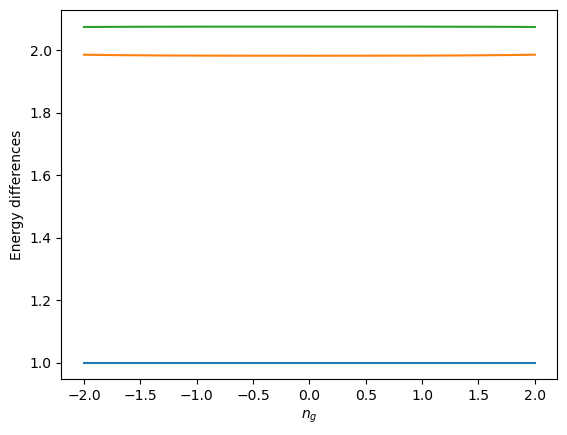

C:\Users\User\anaconda3\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\User\anaconda3\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


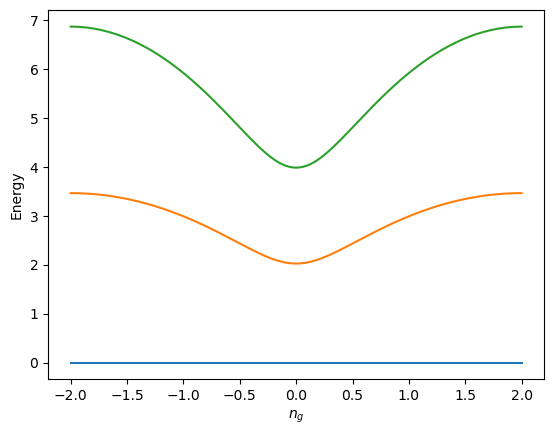

In [237]:

def plot_energy_diff_vs_n_g(amount=amount_of_energies):
    for i in range(amount):
        plt.plot(n_g_array,delta_energy_n_g[:,i]/delta_energy_n_g[:,0])
    plt.xlabel(r'${n_g}$')
    plt.ylabel('Energy differences')
    # plt.title('Energy differences from GS (asymmetric transmon, cavity and chain)')

    # Save the figure as an image (e.g., PNG)
    filename = f'diff_n_g_amount_of_energies_diff_{amount}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.png'
    plt.savefig(filename)
    plt.show()

def plot_energy_vs_n_g(amount=amount_of_energies):
    for i in range(amount):
        plt.plot(n_g_array,eigenvalues_sys[:,i])
    plt.xlabel(r'${n_g}$')
    plt.ylabel('Energy')
    # plt.title('Energy differences from GS (asymmetric transmon, cavity and chain)')

    # Save the figure as an image (e.g., PNG)
    filename = f'n_g_amount_of_energies_{amount}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.png'
    plt.savefig(filename)
    plt.show()

plot_energy_diff_vs_n_g(3)
plot_energy_vs_n_g(3)

## Plot of the differences from the GS

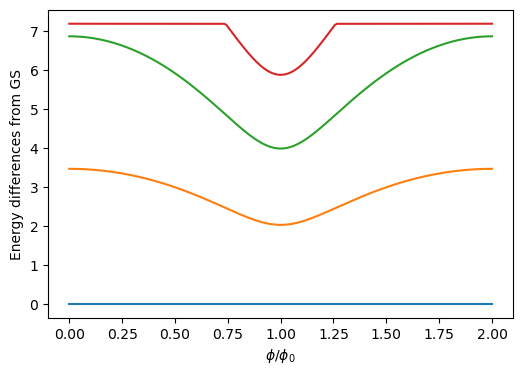

[ 0.        +0.j  2.02610807+0.j  3.98805595+0.j  5.88226244+0.j
  7.19143651+0.j  7.70439639+0.j  9.21739785+0.j  9.44907815+0.j
 11.10933083+0.j 11.17920402+0.j 12.67626733+0.j 13.07327062+0.j
 14.13049925+0.j 14.38287291+0.j 14.89526174+0.j 15.48930964+0.j
 16.40868753+0.j 16.48922879+0.j 16.63986063+0.j 17.99125547+0.j
 18.1759925 +0.j 18.29997489+0.j 18.370352  +0.j 19.86672427+0.j
 20.2642787 +0.j 20.7875259 +0.j 20.79262542+0.j 21.32086252+0.j
 21.57430922+0.j 22.08612697+0.j 22.67950937+0.j 23.59997711+0.j
 23.67902491+0.j 23.83064238+0.j 24.30723939+0.j 24.30725418+0.j
 25.18134126+0.j 25.36590894+0.j 25.49061868+0.j 25.56149989+0.j
 27.05718111+0.j 27.45528669+0.j 27.9773853 +0.j 27.98252861+0.j
 28.51122548+0.j 28.76574544+0.j 28.87850158+0.j 28.87850203+0.j
 29.27699211+0.j 29.86970904+0.j 30.79126673+0.j 30.86882162+0.j
 31.02142344+0.j 31.49732059+0.j 31.49739531+0.j 32.37142718+0.j
 32.55582553+0.j 32.68126223+0.j 32.75264825+0.j 34.24763788+0.j
 34.64629622+0.j 35.16724

In [238]:
def plot_diff_from_GS():
    fig = plt.figure(figsize=(6, 4))
    energies = 4 #eigenvalues_sys.shape[1]
    for i in range(energies):
        plt.plot(flux_array,np.real(eigenvalues_diff_from_GS[:,i]))

    plt.xlabel(r'${\phi}/{\phi_0}$')
    plt.ylabel('Energy differences from GS')
    # plt.title('Energy differences from GS (asymmetric transmon, cavity and chain)')

    # Save the figure as an image (e.g., PNG)
    filename = f'diff_from_GS_amount_of_energies_{energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.png'
    plt.savefig(filename)

    # plt.legend()
    plt.show()
    print(eigenvalues_sys[100,:])
    print(eigenvalues_sys.shape[1])

plot_diff_from_GS()

Now I want to plot the difference between any two energies as a function of the flux E_i-E_j when E_i > E_j. also I want to add a color bar and paint the lines in the graph by the transition probability between the levels i and j that is caused from the transmon-cavity coupling meaning the term (a_down+a_up).
I will first create the transition amplitude matrix - M.

In [244]:
# Define the energy threshold
energy_threshold = 14

# Count how many eigenenergies are ≤ 14 for each flux
num_below_threshold = np.sum(eigenvalues_sys <= energy_threshold, axis=1)

amount_of_energies = num_below_threshold[0]  # eigenvalues_sys.shape[1]
delta_energy = np.zeros((steps,1)) # contains the energy differences, here i will stack the energies
M = np.zeros_like(delta_energy, dtype=complex) # contains the transition probability due to a_down + a_up, here i will stack the probabilities
if cutoff:
    operator = np.kron(np.identity(size_of_transmon_subspace), np.kron((a_down+a_up), np.identity(2**N))) # that's the operator I want to get the transition probability for
else:
    operator = np.kron(np.identity((2*n_0+1)), np.kron((a_down+a_up), np.identity(2**N))) # that's the operator I want to get the transition probability for

print("should be the total dimension:", operator.shape) # sanity test

for i in range(amount_of_energies-1, -1, -1): # a loop that iterates from 19 to 0 including
    print("i =", i)
    for j in range(i-1, -1, -1): # a loop that iterates from i-1 to 0 including
        diff = eigenvalues_diff_from_GS[:,i] - eigenvalues_diff_from_GS[:,j] # should be an array with number of rows as "steps" and one column
        temp = np.hstack((delta_energy, diff.reshape(-1,1))) # here i stack the diff in the delta_energy matrix and reshape the diff column to (-1,1) meaning I want it to be 1 column and the number of rows i leave for numpy to figure out according to the data
        delta_energy = temp
        temp_expectation_vec = np.zeros((steps,1), dtype=complex) # here I want to save the transition probability from j to i for each step because each step have different eigenvectors
        for step in range(steps):
            vec_i = eigenvectors_sys[step,:,i]
            vec_j = eigenvectors_sys[step,:,j]
            M_ij = vec_i.conjugate().dot(operator.dot(vec_j))
            temp_expectation_vec[step,0] = M_ij
        temp_M = np.hstack((M, temp_expectation_vec.reshape(-1,1)))
        M = temp_M


M = M[:, 1:] # cutting the first column of zeros
M = np.abs(M)**2
# M = np.log10(M)
delta_energy = delta_energy[:, 1:] # cutting the first column of zeros
delta_energy = np.abs(delta_energy)

print(M.shape)
print(delta_energy.shape)


should be the total dimension: (147, 147)
i = 6
i = 5
i = 4
i = 3
i = 2
i = 1
i = 0
(200, 21)
(200, 21)


Now I will plot the data with colormap

C:\Users\User\AppData\Local\Temp\ipykernel_29868\3050936250.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


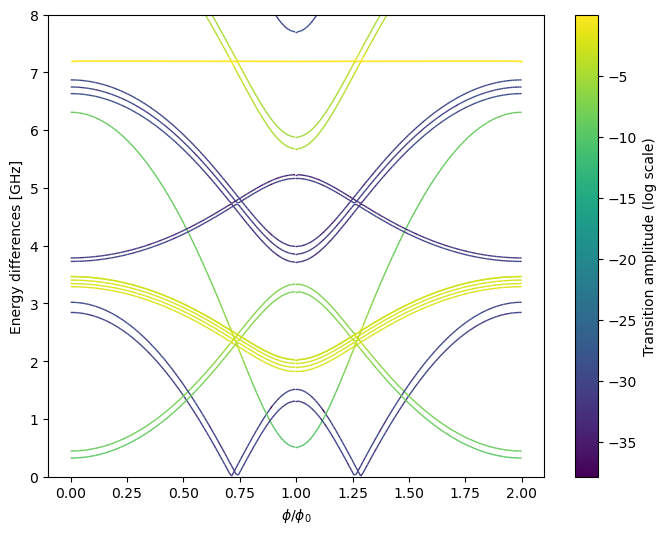

In [245]:
from matplotlib import colors
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection

M_wo_numerical_err = M #np.where(M<1e-10,0,M)

# Force normalization to range [0, 1]
# min_val, max_val = np.min(M_wo_numerical_err), np.max(M_wo_numerical_err)
# normalized_color_values = (M_wo_numerical_err - min_val) / (max_val - min_val)
#
# norm = colors.Normalize(vmin=0, vmax=1, clip=True)

norm = colors.Normalize(vmin=np.min(np.log10(M_wo_numerical_err)),vmax=np.max(np.log10(M_wo_numerical_err))) # normalizes the M values to 0-1
cmap = get_cmap('viridis')
fig, ax = plt.subplots(figsize=(8, 6)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)

for i in range(0, delta_energy.shape[1]):
    points = np.array([flux_array, delta_energy[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
    segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
    lc.set_array(np.log10(M_wo_numerical_err[:,i])) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
    ax.add_collection(lc) # add the linecollection to the ax
    if i == 0:
        # Adding colorbar to show the color scale
        cb = plt.colorbar(lc, ax=ax)
        cb.set_label('Transition amplitude (log scale)')

ax.autoscale() #adjusts the axis limits to fit the data in the subplot
# colorbar = plt.colorbar()
# colorbar.set_label('Custom Value')
# plt.axhline(y=4, color='y', linestyle='-')
# plt.axhline(y=0.8, color='y', linestyle='-')
plt.xlabel(r'${\phi}/{\phi_0}$')
plt.ylabel('Energy differences [GHz]')
#plt.title('Energy differences (asymmetric transmon, cavity and chain)')
plt.ylim(0, 8)
# Include parameter values in the legend without lines
# legend_parameter_values = [f'gamma_L: {gamma_L}', f'gamma_R: {gamma_R}', f'tunneling in the chain: {t}']
# handles = [plt.Line2D([], [], linestyle='None', label=value) for value in legend_parameter_values]
# ax.legend(handles=handles)

# Save the figure as an image (e.g., PNG)
filename = f'1amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.png'
plt.savefig(filename, dpi = 200)

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_29868\2166667830.py:5: RuntimeWarning: divide by zero encountered in log
  M_wo_numerical_err = np.log(np.where(M<1e-10,0,M))
C:\Users\User\AppData\Local\Temp\ipykernel_29868\2166667830.py:9: RuntimeWarning: invalid value encountered in subtract
  normalized_color_values = (M_wo_numerical_err - min_val) / (max_val - min_val)
C:\Users\User\AppData\Local\Temp\ipykernel_29868\2166667830.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_color_values = (M_wo_numerical_err - min_val) / (max_val - min_val)
C:\Users\User\AppData\Local\Temp\ipykernel_29868\2166667830.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


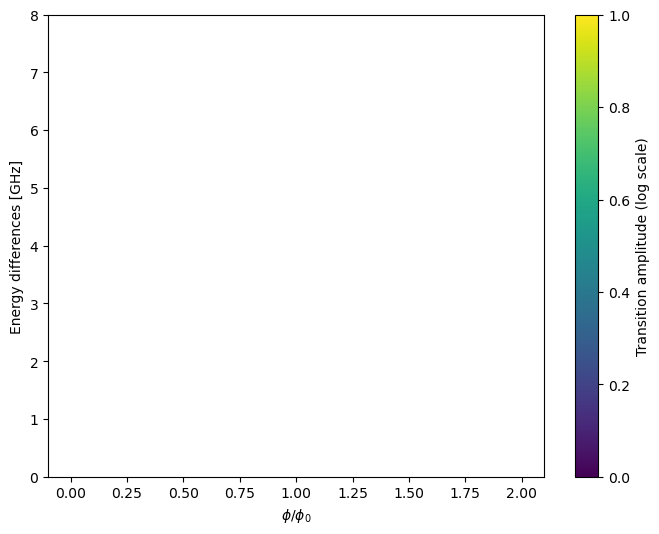

In [241]:
from matplotlib import colors
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection

M_wo_numerical_err = np.log(np.where(M<1e-10,0,M))

# Force normalization to range [0, 1]
min_val, max_val = np.min(M_wo_numerical_err), np.max(M_wo_numerical_err)
normalized_color_values = (M_wo_numerical_err - min_val) / (max_val - min_val)

norm = colors.Normalize(vmin=0, vmax=1, clip=True)

#norm = colors.Normalize(vmin=np.min(np.log10(M_wo_numerical_err)),vmax=np.max(np.log10(M_wo_numerical_err))) # normalizes the M values to 0-1
cmap = get_cmap('viridis')
fig, ax = plt.subplots(figsize=(8, 6)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)

for i in range(0, delta_energy.shape[1]):
    points = np.array([flux_array, delta_energy[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
    segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
    lc.set_array(normalized_color_values[:,i]) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
    ax.add_collection(lc) # add the linecollection to the ax
    if i == 0:
        # Adding colorbar to show the color scale
        cb = plt.colorbar(lc, ax=ax)
        cb.set_label('Transition amplitude (log scale)')

ax.autoscale() #adjusts the axis limits to fit the data in the subplot
# colorbar = plt.colorbar()
# colorbar.set_label('Custom Value')
# plt.axhline(y=4, color='y', linestyle='-')
# plt.axhline(y=0.8, color='y', linestyle='-')
plt.xlabel(r'${\phi}/{\phi_0}$')
plt.ylabel('Energy differences [GHz]')
#plt.title('Energy differences (asymmetric transmon, cavity and chain)')
plt.ylim(0, 8)
# Include parameter values in the legend without lines
# legend_parameter_values = [f'gamma_L: {gamma_L}', f'gamma_R: {gamma_R}', f'tunneling in the chain: {t}']
# handles = [plt.Line2D([], [], linestyle='None', label=value) for value in legend_parameter_values]
# ax.legend(handles=handles)

# Save the figure as an image (e.g., PNG)
filename = f'1amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.png'
plt.savefig(filename, dpi = 200)

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_29868\3682145535.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


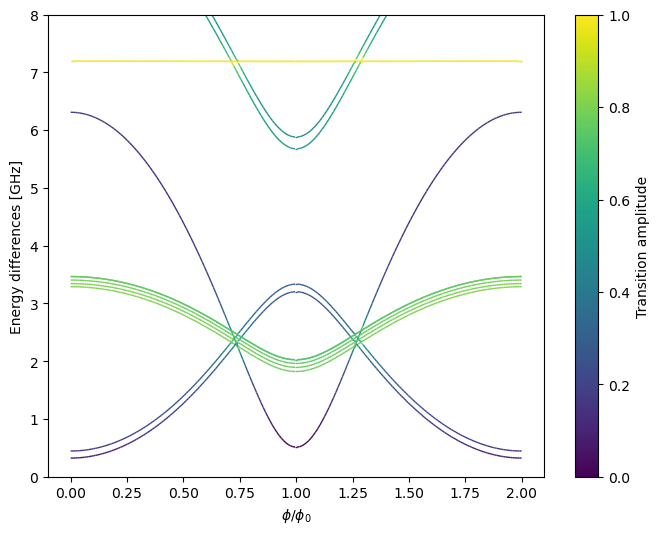

In [242]:
M_filtered = np.copy(M)  # Copy of M for filtering
delta_energy_filtered = np.copy(delta_energy)

# Define a threshold for filtering
threshold = 1e-10  # Adjust based on the problem

# Create a mask: Keep columns where at least one value is above the threshold
mask = np.any(np.abs(M) > threshold, axis=0)

# Apply the mask to both matrices
M_filtered = np.log((M_filtered[:,mask]))
delta_energy_filtered = delta_energy_filtered[:,mask]

# Force normalization to range [0, 1]
min_val, max_val = np.min(M_filtered), np.max(M_filtered)
filtered_normalized_color_values = (M_filtered - min_val) / (max_val - min_val)

norm = colors.Normalize(vmin=0, vmax=1, clip=True)
# norm = colors.Normalize(vmin=np.min(np.log(M_filtered)),vmax=np.max(np.log(M_filtered))) # normalizes the M values to 0-1
cmap = get_cmap('viridis')
fig, ax = plt.subplots(figsize=(8, 6)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)

for i in range(0, delta_energy_filtered.shape[1]):
    points = np.array([flux_array, delta_energy_filtered[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
    segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
    lc.set_array(filtered_normalized_color_values[:,i]) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
    ax.add_collection(lc) # add the linecollection to the ax
    if i == 0:
        # Adding colorbar to show the color scale
        cb = plt.colorbar(lc, ax=ax)
        cb.set_label('Transition amplitude')

ax.autoscale() #adjusts the axis limits to fit the data in the subplot
# colorbar = plt.colorbar()
# colorbar.set_label('Custom Value')
# plt.axhline(y=4, color='y', linestyle='-')
# plt.axhline(y=0.8, color='y', linestyle='-')
plt.xlabel(r'${\phi}/{\phi_0}$')
plt.ylabel('Energy differences [GHz]')
#plt.title('Energy differences (asymmetric transmon, cavity and chain)')
plt.ylim(0, 8)
# Include parameter values in the legend without lines
# legend_parameter_values = [f'gamma_L: {gamma_L}', f'gamma_R: {gamma_R}', f'tunneling in the chain: {t}']
# handles = [plt.Line2D([], [], linestyle='None', label=value) for value in legend_parameter_values]
# ax.legend(handles=handles)

# Save the figure as an image (e.g., PNG)
filename = f'filtered_amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.png'
plt.savefig(filename, dpi = 200)

plt.show()

NameError: name 'energies' is not defined

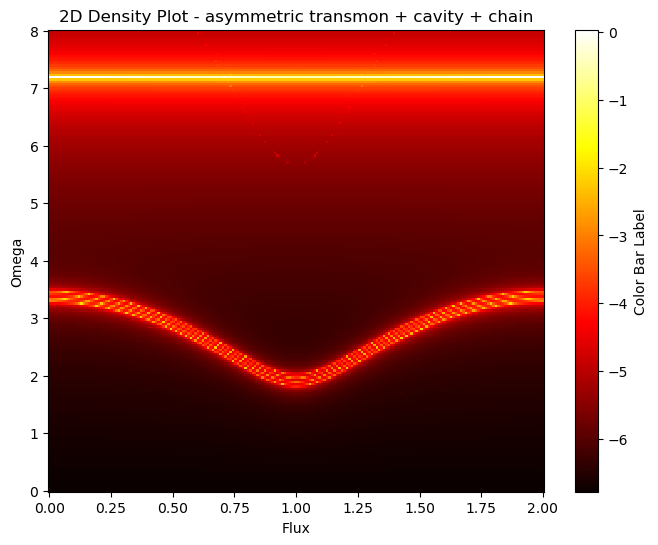

In [243]:
# Generate the flux and omega arrays
omega_array = np.linspace(0,8,num = 200)
kapa = 0.002
T = 1.6669 #80mK in GHz
# Create a meshgrid of flux and omega values
flux_grid, omega_grid = np.meshgrid(np.pi*flux_array, omega_array)

# Define a function that computes the color value based on flux and omega
def color_function(flux, omega): # flux and omega are 2d arrays where the y-axis (0 axis - rows) is the size of omega_array and the x-axis (1 axis - columns) is the size of flux_array.
    s = np.zeros_like(flux)
    for i in range(omega.shape[0]):
        for j in range(flux.shape[1]):
            temp_s = 0
            for k in range(M.shape[1]):
                temp_s += (M[j,k]**2)*(kapa**2)/((delta_energy[j,k]-omega[i,j])**2 + kapa**2)
            s[i,j] = temp_s
    return s

# Compute the color values for each combination of flux and omega. This is a 2d array of size omega_array X flux_array
color_values = color_function(flux_grid, omega_grid)

# Create a 2D density plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(flux_array, omega_array, np.log10(color_values), cmap='hot')  # Adjust the colormap as needed
plt.colorbar(label='Color Bar Label')  # Add a color bar for reference
plt.xlabel('Flux')
plt.ylabel('Omega')
plt.title('2D Density Plot - asymmetric transmon + cavity + chain')

# Save the figure as an image (e.g., PNG)
filename = f'density_s(w,phi)_amount_of_energies_{energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_Transmon_cutoff_{cutoff}_{size_of_transmon_subspace}.png'
plt.savefig(filename)

plt.show()


## Adding a plot of s(w,phi) in 2d plot - Second order FGR

In [ ]:
amount_of_energies_2 = 10 #6*2**N
amount_of_energy_diff = np.sum(list(range(amount_of_energies_2)))
delta_energy_2 = np.zeros((steps,amount_of_energies_2,amount_of_energies_2), dtype=complex) # contains the energy differences, 0 axies in the size of flux array, 1 axies and 2 axies in size of amount of energies. so in each [:,i,j] i will the diff E_i-E_j
M_2 = np.zeros_like(delta_energy_2, dtype=complex) # contains the transition probability due to a_down + a_up, here i will put the probabilities. It will contain <i|a_down+a_up|j> in the i'th row and j'th column

if cutoff:
    operator_2 = np.kron(np.identity(size_of_transmon_subspace), np.kron((a_down+a_up), np.identity(2**N))) # that's the operator I want to get the transition probability for
else:
    operator_2 = np.kron(np.identity((2*n_0+1)), np.kron((a_down+a_up), np.identity(2**N))) # that's the operator I want to get the transition probability for

print("operator should be of total dimension:", operator_2.shape) # sanity test

for i in range(amount_of_energies_2): # a loop that iterates from 0 to 6 including
    print("i =", i)
    for j in range(amount_of_energies_2): # a loop that iterates from 0 to 6 including
        diff = eigenvalues_sys[:,i] - eigenvalues_sys[:,j] # should be an array with number of rows as "steps" (and flux_array) and one column
        delta_energy_2[:,i,j] = diff
        temp_expectation_vec = np.zeros((steps,1), dtype=complex)
        for step in range(steps):
            vec_i = eigenvectors_sys[step,:,i]
            vec_j = eigenvectors_sys[step,:,j]
            M_ij = vec_i.conj().dot(operator_2.dot(vec_j))# here I want to save the transition probability from j to i for each step because each step have different eigenvectors
            M_2[step,i,j] = M_ij


M_2 = np.abs(M_2)
#delta_energy_2 = np.abs(delta_energy_2)
# delta_energy_2 = np.real(delta_energy_2)
print(M_2.shape)
print(delta_energy_2.shape)
print("are the eigenvalues complex?:",np.iscomplex(eigenvalues_sys).any())


In [ ]:

from matplotlib import colors
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection

# M_2 and delta energy are (200,7,7) mat where each layer is <i|a_up+a_down|j> i want to get only the upper triangle of each layer (k=1) and make it 1D and put in a matrix of (200,21)
M_wo_numerical_err = np.where(M_2<1e-14,0,M_2)

def draw_energy_diff_color_FGR(Mat):
    M_temp = np.zeros((steps,amount_of_energy_diff))
    print(M_temp.shape)
    delta_energy_temp = np.zeros_like(M_temp)
    upper_triangle_indices = np.triu_indices(Mat.shape[1],k=1)
    for i in range(Mat.shape[0]):
        upper_triangle = Mat[i][upper_triangle_indices]
        M_temp[i,:] = upper_triangle
        delta_energy_temp[i,:] = np.abs(delta_energy_2[i][upper_triangle_indices])

    norm = colors.Normalize(vmin=np.min(np.log10(M_2)),vmax=np.max(np.log10(M_2))) # normalizes the M values to 0-1
    cmap = get_cmap('viridis')
    fig, ax = plt.subplots(figsize=(8, 6)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)
    for i in range(0, amount_of_energy_diff):
        points = np.array([flux_array, delta_energy_temp[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
        segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
        lc.set_array(np.log10(M_temp[:,i])) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
        ax.add_collection(lc) # add the linecollection to the ax
        if i == 0:
            # Adding colorbar to show the color scale
            cb = plt.colorbar(lc, ax=ax)
            cb.set_label('Transition amplitude (log scale)')
    ax.autoscale() #adjusts the axis limits to fit the data in the subplot
    plt.xlabel(r'${\phi}/{\phi_0}$')
    plt.ylabel('Energy differences')
    # plt.title('Energy differences (asymmetric transmon and cavity)')
    plt.ylim(0, 7)

    # Save the figure as an image (e.g., PNG)
    filename = f'FGR_amount_of_energies_{amount_of_energies_2}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}.png'
    plt.savefig(filename)
    plt.show()
    return M_temp, delta_energy_temp

M_temp, delta_energy_temp = draw_energy_diff_color_FGR(M_wo_numerical_err)

### This is second order only!


omega = 0


C:\Users\User\AppData\Local\Temp\ipykernel_29868\1289926370.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  s[o,j] = 2*np.pi*temp


omega = 1
omega = 2
omega = 3
omega = 4
omega = 5
omega = 6
omega = 7
omega = 8
omega = 9
omega = 10
omega = 11
omega = 12
omega = 13
omega = 14
omega = 15
omega = 16
omega = 17
omega = 18
omega = 19
omega = 20
omega = 21
omega = 22
omega = 23
omega = 24
omega = 25
omega = 26
omega = 27
omega = 28
omega = 29
omega = 30
omega = 31
omega = 32
omega = 33
omega = 34
omega = 35
omega = 36
omega = 37
omega = 38
omega = 39
omega = 40
omega = 41
omega = 42
omega = 43
omega = 44
omega = 45
omega = 46
omega = 47
omega = 48
omega = 49
omega = 50
omega = 51
omega = 52
omega = 53
omega = 54
omega = 55
omega = 56
omega = 57
omega = 58
omega = 59
omega = 60
omega = 61
omega = 62
omega = 63
omega = 64
omega = 65
omega = 66
omega = 67
omega = 68
omega = 69
omega = 70
omega = 71
omega = 72
omega = 73
omega = 74
omega = 75
omega = 76
omega = 77
omega = 78
omega = 79
omega = 80
omega = 81
omega = 82
omega = 83
omega = 84
omega = 85
omega = 86
omega = 87
omega = 88
omega = 89
omega = 90
omega = 91
omega = 

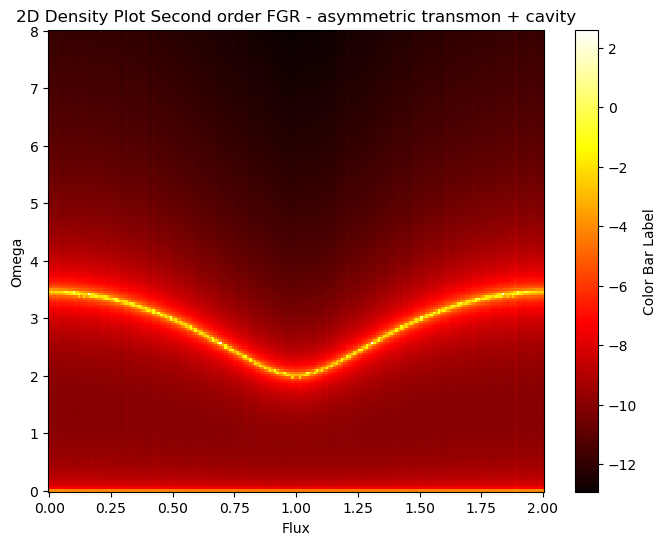

In [246]:
# Generate the flux and omega arrays
omega_array = np.linspace(0,8,num = 200)
kapa = 0.002
epsilon = 0.00001
# Create a meshgrid of flux and omega values
flux_grid_2, omega_grid_2 = np.meshgrid(np.pi*flux_array, omega_array)

# Define a function that computes the color value based on flux and omega
def color_function(flux, omega): # flux and omega are 2d arrays where the y-axis (0 axis - rows) is the size of omega_array and the x-axis (1 axis - columns) is the size of flux_array.
    s = np.zeros_like(flux)
    for o in range(omega.shape[0]): #amount of omegas
        print("omega =", o)
        for j in range(flux.shape[1]): #amount of fluxes
            temp = 0
            for f in range(M_2.shape[1]): #axis 1 of M is the amount of energies (ie. 7) rows
                for i in range(M_2.shape[2]): #axis 2 of M is the amount of energies (ie. 7) columns
                    temp_m = 0
                    for m in range(M_2.shape[2]):
                        if m!=i or m!=f:
                            temp_m += (M_2[j,f,m]*M_2[j,m,i])/((delta_energy_2[j,m,i]-omega[o,j])-1j*epsilon)
                    temp += np.abs(temp_m)**2*(kapa**2)/((delta_energy_2[j,f,i]-2*omega[o,j])**2 + kapa**2)
            s[o,j] = 2*np.pi*temp
    return s


# Compute the color values for each combination of flux and omega. This is a 2d array of size omega_array X flux_array
color_values = color_function(flux_grid_2, omega_grid_2)

# Create a 2D density plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(flux_array, omega_array, np.log10(color_values), cmap='hot')  # Adjust the colormap as needed
plt.colorbar(label='Color Bar Label')  # Add a color bar for reference
plt.xlabel('Flux')
plt.ylabel('Omega')
plt.title('2D Density Plot Second order FGR - asymmetric transmon + cavity')

# Save the figure as an image (e.g., PNG)
filename = f'second_order_FGR_s(w,phi)_amount_of_energies_{amount_of_energies_2}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}.png'
plt.savefig(filename)

plt.show()


## Painting the energy difference plot with the second order values of FGR

In [ ]:
delta_energy_2_postive = np.where(delta_energy_2<0, 0, delta_energy_2)
def draw_energy_diff_color_2nd_FGR(M_2):
    # M_temp = np.zeros((steps,amount_of_energy_diff))
    # print(M_temp.shape)
    # delta_energy_temp = np.zeros_like(M_temp)
    # upper_triangle_indices = np.triu_indices(M_2.shape[1],k=1)
    # for i in range(M_2.shape[0]):
    #     upper_triangle = M_2[i][upper_triangle_indices]
    #     M_temp[i,:] = upper_triangle
    #     delta_energy_temp[i,:] = delta_energy_2[i][upper_triangle_indices]

    FGR2 = np.zeros_like(M_2, dtype=complex)
    delta_energy_div_2 = delta_energy_2_postive/2

    for f in range(M_2.shape[1]): #axis 1 of M is the amount of energies (ie. 7) rows
        for i in range(M_2.shape[2]): #axis 2 of M is the amount of energies (ie. 7) columns
            for m in range(M_2.shape[2]):
                if m!=i and m!=f:
                    FGR2[:,f,i] +=(M_2[:,f,m]*M_2[:,m,i])/((delta_energy_2[:,m,i]-delta_energy_2_postive[:,f,i]/2)-1j*epsilon)
    FGR2 = np.abs(FGR2)**2
    FGR2 = FGR2.reshape((FGR2.shape[0], -1))
    delta_energy_div_2 = delta_energy_div_2.reshape((delta_energy_div_2.shape[0], -1))
    print("are the delta energy complex?:",np.iscomplex(delta_energy_div_2).any())
    norm = colors.Normalize(vmin=np.min(np.log10(FGR2)),vmax=np.max(np.log10(FGR2))) # normalizes the M values to 0-1
    cmap = get_cmap('viridis')
    fig, ax = plt.subplots(figsize=(8, 6)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)
    print(delta_energy_div_2.shape)
    print(FGR2.shape)

    for i in range(delta_energy_div_2.shape[1]):
        points = np.array([flux_array, delta_energy_div_2[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
        segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
        lc.set_array(np.log10(FGR2[:,i])) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
        ax.add_collection(lc) # add the linecollection to the ax
        if i == 0:
            # Adding colorbar to show the color scale
            cb = plt.colorbar(lc, ax=ax)
            cb.set_label('Transition amplitude 2nd order FGR (log scale)')
    ax.autoscale() #adjusts the axis limits to fit the data in the subplot
    plt.xlabel(r'${\phi}/{\phi_0}$')
    plt.ylabel(r'${\Delta}E/2$')
    # plt.title('Energy differences (asymmetric transmon and cavity)')
    plt.ylim(0, 7)

    # Save the figure as an image (e.g., PNG)
    filename = f'2nd_order_FGR_amount_of_energies_{amount_of_energies_2}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}.png'
    plt.savefig(filename)
    plt.show()

draw_energy_diff_color_2nd_FGR(M_2)